Simulation of different protocols that have been used to test mpe and mapd and see if we can process ivim in patients. Comparing our b values to those used by previous studies.

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
import csv

import scipy.optimize as op
import scipy.stats
from scipy.optimize import curve_fit
import scipy.io

from scipy.stats import rice

import random
import pickle

# Simulation 

In [3]:
def random():
    A = np.random.random()
    B = np.random.random()
    if B>=.5:
        C = 1
    else:
        C = -1
    return A*C    

def Noise(I): #original noise function
    N = []
    for i in range(0,len(I)):
        N.append(I[i]+(I[i]/10)*random())
    return N

def NoiseG(I):  #noise with gaussian distribution
    N = []
    for i in range(0,len(I)):
        N.append(I[i] + (I[i]/10)*np.random.normal(0,1,1)[0])
    return N

def NoiseR(I): # noise with rician distribution
    N = []
    for i in range(0,len(I)):
        g1 = np.random.normal(0,.5,1)
        g2 = np.random.normal(0,.5,1)
        R = np.sqrt(g1**2 + g2**2)[0]
        N.append(I[i] +(I[i]/10)*R)
    return N

def func(b,f,Ds,D):
    Sig = f*np.exp(-Ds*b)+(1-f)*np.exp(-D*b) #IVIM model signal
    return Sig

def func1(b,f,D):
    return (1-f)*np.exp(-D*b)

def func2(b,f,Ds):
    return f*np.exp(-Ds*b)

def percentdiff(A,B):
    pd = 200*np.abs(A-B)/(A+B)
    return pd

def percenterr(T,M):
    return 100*(T-M)/T

def ivim(Bvals,f,Ds,D):
    S = []
    for i in range(len(Bvals)):
        S.append(f*np.exp(-Ds*Bvals[i])+(1-f)*np.exp(-D*Bvals[i]))
    return S

def percenterr(T,M):
    return 100*(T-M)/T
B = [0,111, 222, 333, 444, 556, 667, 778, 889, 1000]
def diffivim(Bvals,f,D): #high b values
    S = []
    for i in range(len(Bvals)):
        S.append(func1(Bvals[i],f,D))
    return S

def plotfunc2(Bvals,f,Ds):
    S = []
    for i in range(len(Bvals)):
        S.append(func2(Bvals[i],f,Ds))
    return S
# now comparing different fits (just to get pretty plot)
#B = [0,111, 222, 333, 444, 556, 667, 778, 889, 1000]
def twostepfit(IVIM,Bvals,B_500): #for Fine B vals
    p01 = [0.05,.0009] #f,D best
    p02 = [0.05,.009] #f,Ds best
    popt,pcov = op.curve_fit(func1,Bvals[B_500:],IVIM[B_500:], p01,bounds = (0,[1,1]),maxfev = 10000)
    fF = popt[0]
    DF = popt[1]
    IVIM2 = np.array(IVIM) - np.array(diffivim(Bvals,fF,DF))
    popt,pcov = op.curve_fit(func2,Bvals[:B_500-1],IVIM2[:B_500-1], p02,bounds = (0,[1,1]),maxfev = 10000)
    fF2 = popt[0]
    DsF = popt[1]
    return [fF2,DsF,DF]

#With larger maxfev for YAO
def twostepfit1(IVIM,Bvals,B_500): #for Fine B vals
    p01 = [0.05,.0009] #f,D best
    p02 = [0.05,.009] #f,Ds best
    popt,pcov = op.curve_fit(func1,Bvals[B_500:],IVIM[B_500:], p01,bounds = (0,[1,1]),maxfev=10000)
    fF = popt[0]
    DF = popt[1]
    IVIM2 = np.array(IVIM) - np.array(diffivim(Bvals,fF,DF))
    popt,pcov = op.curve_fit(func2,Bvals[:B_500-1],IVIM2[:B_500-1], p02,bounds = (0,[1,1]),maxfev = 10000)
    fF2 = popt[0]
    DsF = popt[1]
    return [fF2,DsF,DF]

def splitfit(IVIM,Bvals,B_500): #B_500 is the index of the b value that is >=500 (13)
    #p01 = [.02,.0058] #f,D
    p01 = [.05,.0009]
    popt,pcov = op.curve_fit(func1,Bvals[B_500:],IVIM[B_500:], p01,bounds = (0,[.1,1]))
    f1 = popt[0]
    D_fit = popt[1]
    p02 = [.05,.009,D_fit] #f,Ds,D
    popt,pcov = op.curve_fit(func,Bvals,IVIM, p02,bounds = ([0,0,D_fit],[1,1,D_fit+.001]))
    fF = popt[0]
    DsF = popt[1]
    DF = popt[2]
    return [fF,DsF,DF]
def simplefit(IVIM,Bvals):
    p0 = [.05,.009,.0009] #f, Ds,D best
    popt,pcov = op.curve_fit(func,Bvals,IVIM, p0,bounds = (0,[1,1,1]),maxfev = 10000)
    fF = popt[0]
    DsF = popt[1]
    DF = popt[2]
    return [fF,DsF,DF]
def twosteprun(f,Ds,D,S,B_500):
    #SigN = ivim(B,f,Ds,D)
    [fF,DsF,DF] = twostepfit(S,B,B_500)
    return [fF,DsF,DF],[percenterr(f,fF),percenterr(Ds,DsF),percenterr(D,DF)]
def splitrun(f,Ds,D,S,B_500):
    #SigN = ivim(B,f,Ds,D)
    [fF,DsF,DF] = splitfit(S,B,B_500)
    return [fF,DsF,DF],[percenterr(f,fF),percenterr(Ds,DsF),percenterr(D,DF)]
def simplerun(f,Ds,D,S):
    #SigN = ivim(B,f,Ds,D)
    [fF,DsF,DF] = simplefit(S,B)
    return [fF,DsF,DF],[percenterr(f,fF),percenterr(Ds,DsF),percenterr(D,DF)]

def twosteprunBs(f,Ds,D,S,B_500,B):
    #SigN = ivim(B,f,Ds,D)
    [fF,DsF,DF] = twostepfit(S,B,B_500)
    return [fF,DsF,DF],[percenterr(f,fF),percenterr(Ds,DsF),percenterr(D,DF)]
# for yao
def twosteprunBs1(f,Ds,D,S,B_500,B):
    #SigN = ivim(B,f,Ds,D)
    [fF,DsF,DF] = twostepfit1(S,B,B_500)
    return [fF,DsF,DF],[percenterr(f,fF),percenterr(Ds,DsF),percenterr(D,DF)]

def simplerunBs(f,Ds,D,S,B):
    #SigN = ivim(B,f,Ds,D)
    [fF,DsF,DF] = simplefit(S,B)
    return [fF,DsF,DF],[percenterr(f,fF),percenterr(Ds,DsF),percenterr(D,DF)]

def splitrunBs(f,Ds,D,S,B_500,B):
    #SigN = ivim(B,f,Ds,D)
    [fF,DsF,DF] = splitfit(S,B,B_500)
    return [fF,DsF,DF],[percenterr(f,fF),percenterr(Ds,DsF),percenterr(D,DF)]


def NoiseRSNR(I,SNR): # noise with rician distribution
    N = [] 
    for i in range(0,len(I)):
        g1 = np.random.normal(0,1,1) #mean, std, #of values
        g2 = np.random.normal(0,1,1) #std has been .5... I LIED ABOUT SNR oh no
        R = np.sqrt(g1**2 + g2**2)[0]
        N.append(I[i] +(I[i]/SNR)*R) #SNR = 1,10,22,100,150,inf
    return N

def NoiseRice(I,sigma): # noise with rician distribution
    N = [] 
    #v = .79 # calculated from images on 6/11/19
    #sigma = .013 #(std of noise!)
    #v = 0.00434 #scaled = .79/182
    v = .005816 #scaled 6/27/19
    b = v/sigma
    r = rice.rvs(b, scale = sigma, size=len(I))
    for i in range(0,len(I)):
        N.append(I[i] +r[i]) #SNR = 1,10,22,100,150,inf
    return N

def MPE(X):
    return np.mean(X)

def MAPD(X):
    return np.sum([abs(i) for i in X])/len(X)


# Number of b values and b values used

## TJC: Our b values, Fed: Federau 2012 paper, Jal: Jalnefjord 2018 paper, Yao: Yao 2015 paper

## this first run: using the cut off that is given in the papers: 
### TJC: 222, Fed: 200, Jal: 120, Yao: 200

In [16]:
# comparing NUMBER OF b values for 2step run with rician noise 22 and bt = 222
BFED = [0,10,20,40,80,110,140,170,200,300,400,500,600,700,800,900] #FEDerau protocol 2012
BJAL = [0,120,350,575,800] #JALnefjord protocol 2018
BYAO = [0,20,40,80,110,140,170,200,300,400,500,600,700,800,900,1000] #YAO protocol 2015
BTJC = [0,111,222,333,444,556,667,778,889,1000] #previous protocol
TSR_FED = [[],[],[],[]] 
TSR_JAL = [[],[],[],[]] 
TSR_YAO = [[],[],[],[]] 
TSR_TJC = [[],[],[],[]] 
FDsD = [[],[],[],[]] 
for i in range(10000):
    f = .05 + .035*random()
    Ds = .009 + .006*random()
    D = .0009 + .0006*random()
    FDsD[1].append(f),FDsD[2].append(Ds),FDsD[3].append(D)
    #FED
    SigFED = ivim(BFED,f,Ds,D)
    SFED = NoiseRice(SigFED,.01)
    #[fB,DsB,DB],[ferr,Dserr,Derr] = simplerunBs(f,Ds,D,SFED,BFED) #bt = 200 (split and 2 step run)
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprunBs1(f,Ds,D,SFED,8,BFED) #bt = 200 (split and 2 step run)
    TSR_FED[0].append(ferr),TSR_FED[0].append(Dserr),TSR_FED[0].append(Derr)
    TSR_FED[1].append(fB),TSR_FED[2].append(DsB),TSR_FED[3].append(DB)
    #JAL
    SigJAL = ivim(BJAL,f,Ds,D)
    SJAL = NoiseRice(SigJAL,.01)
    #[fB,DsB,DB],[ferr,Dserr,Derr] = simplerunBs(f,Ds,D,SJAL,BJAL) #bt = 120/350 (unclear)
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprunBs1(f,Ds,D,SJAL,2,BJAL) #bt = 120/350 (unclear)
    TSR_JAL[0].append(ferr),TSR_JAL[0].append(Dserr),TSR_JAL[0].append(Derr)
    TSR_JAL[1].append(fB),TSR_JAL[2].append(DsB),TSR_JAL[3].append(DB)
    #YAO
    SigYAO = ivim(BYAO,f,Ds,D)
    SYAO = NoiseRice(SigYAO,.01)
    #[fB,DsB,DB],[ferr,Dserr,Derr] = simplerunBs(f,Ds,D,SYAO,BYAO) #bt = 200 
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprunBs1(f,Ds,D,SYAO,7,BYAO) #bt = 200 
    TSR_YAO[0].append(ferr),TSR_YAO[0].append(Dserr),TSR_YAO[0].append(Derr)
    TSR_YAO[1].append(fB),TSR_YAO[2].append(DsB),TSR_YAO[3].append(DB)
    #TJC
    SigTJC = ivim(BTJC,f,Ds,D)
    STJC = NoiseRice(SigTJC,.01)
    #[fB,DsB,DB],[ferr,Dserr,Derr] = simplerunBs(f,Ds,D,STJC,BTJC)
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprunBs1(f,Ds,D,STJC,2,BTJC)
    TSR_TJC[0].append(ferr),TSR_TJC[0].append(Dserr),TSR_TJC[0].append(Derr)
    TSR_TJC[1].append(fB),TSR_TJC[2].append(DsB),TSR_TJC[3].append(DB)
    

/Users/neuroimaging/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


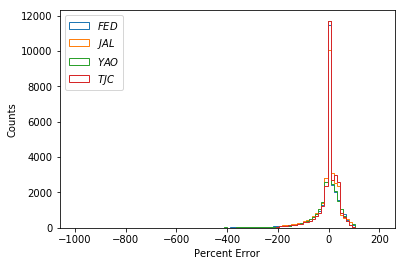

average error:  -20.3778737428317
average error:  -5.0095730784844585
average error:  -20.99037526048625
average error:  -1.6085208441384988
absolute error:  42.19583236191311
absolute error:  29.13632442260767
absolute error:  42.47459622213289
absolute error:  25.44782407327535


In [17]:
pl.hist(TSR_FED[0],bins = 100,range =(-1000,200),histtype = 'step',label = '$FED$')
pl.hist(TSR_JAL[0],bins = 100,range=(-1000,200),histtype = 'step',label = '$JAL$')
pl.hist(TSR_YAO[0],bins = 100,range=(-1000,200),histtype = 'step',label = '$YAO$')
pl.hist(TSR_TJC[0],bins = 100,range=(-1000,200),histtype = 'step',label = '$TJC$')


pl.legend(loc=2)
#pl.text(-990,3000,'10000 runs\n222 MPE = -27.1%\n333 MPE = -123.6%\n556 MPE = -93.9%')
#pl.text(-990,1000,'222 MAPD = 45.7%\n333 MAPD = 157.7%\n556 MAPD = 128.1%')
pl.ylabel('Counts')
pl.xlabel('Percent Error')
#pl.savefig('/Users/neuroimaging/Desktop/btdistribution.tif',dpi=1000)
pl.show()

print('average error: ',MPE(TSR_FED[0]))
print('average error: ',MPE(TSR_JAL[0]))
print('average error: ',MPE(TSR_YAO[0]))
print('average error: ',MPE(TSR_TJC[0]))
print('absolute error: ', MAPD(TSR_FED[0]))
print('absolute error: ', MAPD(TSR_JAL[0]))
print('absolute error: ', MAPD(TSR_YAO[0]))
print('absolute error: ', MAPD(TSR_TJC[0]))

In [6]:
# ferror 
Ferr_FED = []
i = np.array(range(10000))*3
for j in i:
    Ferr_FED.append(TSR_FED[0][j])
    
Ferr_JAL = []
i = np.array(range(10000))*3
for j in i:
    Ferr_JAL.append(TSR_JAL[0][j])
    
Ferr_YAO = []
i = np.array(range(10000))*3
for j in i:
    Ferr_YAO.append(TSR_YAO[0][j])
    
Ferr_TJC = []
i = np.array(range(10000))*3
for j in i:
    Ferr_TJC.append(TSR_TJC[0][j])
    
print('average error: ',MPE(Ferr_FED))
print('average error: ',MPE(Ferr_JAL))
print('average error: ',MPE(Ferr_YAO))
print('average error: ',MPE(Ferr_TJC))
print('absolute error: ',MAPD(Ferr_FED))
print('absolute error: ',MAPD(Ferr_JAL))
print('absolute error: ',MAPD(Ferr_YAO))
print('absolute error: ',MAPD(Ferr_TJC))

average error:  -577.5387686308692
average error:  -545.4400420209606
average error:  -599.7856862383758
average error:  -601.898953274092
absolute error:  621.7047340229196
absolute error:  605.0232617940295
absolute error:  642.5822076914367
absolute error:  651.248818749115


In [28]:
# Dstar err
# ferror 
Dserr_FED = []
i = np.array(range(1000))*3+1
for j in i:
    Dserr_FED.append(TSR_FED[0][j])
    
Dserr_JAL = []
i = np.array(range(1000))*3+1
for j in i:
    Dserr_JAL.append(TSR_JAL[0][j])
    
Dserr_YAO = []
i = np.array(range(1000))*3+1
for j in i:
    Dserr_YAO.append(TSR_YAO[0][j])
    
Dserr_TJC = []
i = np.array(range(1000))*3+1
for j in i:
    Dserr_TJC.append(TSR_TJC[0][j])
    
print('average error: ',np.mean(Dserr_FED))
print('average error: ',np.mean(Dserr_JAL))
print('average error: ',np.mean(Dserr_YAO))
print('average error: ',np.mean(Dserr_TJC))
print('absolute error: ',MAPD(Dserr_FED))
print('absolute error: ',MAPD(Dserr_JAL))
print('absolute error: ',MAPD(Dserr_YAO))
print('absolute error: ',MAPD(Dserr_TJC))

average error:  -58.3837607084
average error:  -23.0535693901
average error:  -40.4139085867
average error:  -23.0535693901
absolute error:  118.518488814
absolute error:  46.012862094
absolute error:  106.153758068
absolute error:  46.012862094


In [29]:
# D err
Derr_FED = []
i = np.array(range(1000))*3+2
for j in i:
    Derr_FED.append(TSR_FED[0][j])
    
Derr_JAL = []
i = np.array(range(1000))*3+2
for j in i:
    Derr_JAL.append(TSR_JAL[0][j])
    
Derr_YAO = []
i = np.array(range(1000))*3+2
for j in i:
    Derr_YAO.append(TSR_YAO[0][j])
    
Derr_TJC = []
i = np.array(range(1000))*3+2
for j in i:
    Derr_TJC.append(TSR_TJC[0][j])
    
print('average error: ',np.mean(Derr_FED))
print('average error: ',np.mean(Derr_JAL))
print('average error: ',np.mean(Derr_YAO))
print('average error: ',np.mean(Derr_TJC))
print('absolute error: ',MAPD(Derr_FED))
print('absolute error: ',MAPD(Derr_JAL))
print('absolute error: ',MAPD(Derr_YAO))
print('absolute error: ',MAPD(Derr_TJC))

average error:  2.89520282559
average error:  5.14502861901
average error:  2.61698299997
average error:  2.71434468007
absolute error:  4.78771043976
absolute error:  7.1478484954
absolute error:  4.18384046737
absolute error:  4.43831442084


# Just looking at the 19 b values again 

In [7]:
# comparing NUMBER OF b values for 2step run with rician noise 22 and bt = 222
BTJC = [0,111,222,333,444,556,667,778,889,1000] #previous protocol
BTJC2 = [0, 0, 22, 44, 67, 89, 111, 133, 156, 178, 200, 222, 333, 444, 556, 667, 778, 889, 1000]
TSR_TJC2 = [[],[],[],[]] 
TSR_TJC = [[],[],[],[]] 
FDsD = [[],[],[],[]] 
for i in range(100):
    f = .05 + .035*random()
    Ds = .009 + .006*random()
    D = .0009 + .0006*random()
    FDsD[1].append(f),FDsD[2].append(Ds),FDsD[3].append(D)
    #TJC
    SigTJC = ivim(BTJC,f,Ds,D)
    STJC = NoiseRice(SigTJC,.01)
    #[fB,DsB,DB],[ferr,Dserr,Derr] = simplerunBs(f,Ds,D,STJC,BTJC)
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprunBs1(f,Ds,D,STJC,2,BTJC)
    TSR_TJC[0].append(ferr),TSR_TJC[0].append(Dserr),TSR_TJC[0].append(Derr)
    TSR_TJC[1].append(fB),TSR_TJC[2].append(DsB),TSR_TJC[3].append(DB)
    #TJC2
    SigTJC2 = ivim(BTJC2,f,Ds,D)
    STJC2 = NoiseRice(SigTJC2,.01)
    #[fB,DsB,DB],[ferr,Dserr,Derr] = simplerunBs(f,Ds,D,STJC,BTJC)
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprunBs1(f,Ds,D,STJC2,11,BTJC2)
    TSR_TJC2[0].append(ferr),TSR_TJC2[0].append(Dserr),TSR_TJC2[0].append(Derr)
    TSR_TJC2[1].append(fB),TSR_TJC2[2].append(DsB),TSR_TJC2[3].append(DB)
    

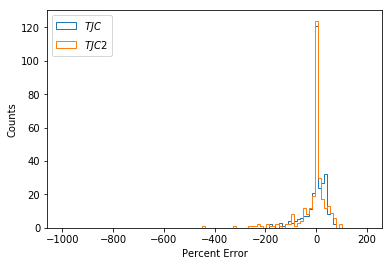

average error:  -1.762851552064896
average error:  -35.09537997138862
absolute error:  25.60108782375626
absolute error:  57.25784336794543


In [8]:
pl.hist(TSR_TJC[0],bins = 100,range=(-1000,200),histtype = 'step',label = '$TJC$')
pl.hist(TSR_TJC2[0],bins = 100,range=(-1000,200),histtype = 'step',label = '$TJC2$')


pl.legend(loc=2)
#pl.text(-990,3000,'10000 runs\n222 MPE = -27.1%\n333 MPE = -123.6%\n556 MPE = -93.9%')
#pl.text(-990,1000,'222 MAPD = 45.7%\n333 MAPD = 157.7%\n556 MAPD = 128.1%')
pl.ylabel('Counts')
pl.xlabel('Percent Error')
#pl.savefig('/Users/neuroimaging/Desktop/btdistribution.tif',dpi=1000)
pl.show()

print('average error: ',MPE(TSR_TJC[0]))
print('average error: ',MPE(TSR_TJC2[0]))
print('absolute error: ', MAPD(TSR_TJC[0]))
print('absolute error: ', MAPD(TSR_TJC2[0]))